In [4]:
import os
import scipy.io

training_dir = os.path.join('..', 'data', 'training')

training_data = {'normal': [], 'noisy': []}
max_len = 9000

for Class in ['normal', 'noisy']:
    class_dir = os.path.join(training_dir, Class)
    for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
        mat_data = scipy.io.loadmat(file)
        sequence = mat_data['val'][0]
        if len(sequence) >= 9000:
          normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
          padded_sequence = normalised_sequence[:max_len]
          training_data[Class].append(padded_sequence)
        
print("Number of files per class (training) \n")
print(f"normal: {len(training_data['normal'])}")
print(f"noisy: {len(training_data['noisy'])}")

Number of files per class (training) 

normal: 4529
noisy: 145


In [44]:
!pip install py-ecg-detectors

In [81]:
def get_heart_rate(peaks):
    if len(peaks) > 1:
        peak_distances = []
        for i in range(len(peaks)-1):
            peak_distances.append(peaks[i+1]-peaks[i])
        return round((300/np.mean(peak_distances))*60)
    return -1

def get_max_RR(peaks):
    if len(peaks) > 1:
        peak_distances = [peaks[0]]
        for i in range(len(peaks)-1):
            peak_distances.append(peaks[i+1]-peaks[i])

        return round(max(peak_distances)/300, 3)
    return -1

def get_RR_ratio(peaks):
    if len(peaks) > 1:
        peak_distances = [peaks[0]]
        for i in range(len(peaks)-1):
            peak_distances.append(peaks[i+1]-peaks[i])

        return round(max(peak_distances)/min(peak_distances), 3)
    return -1

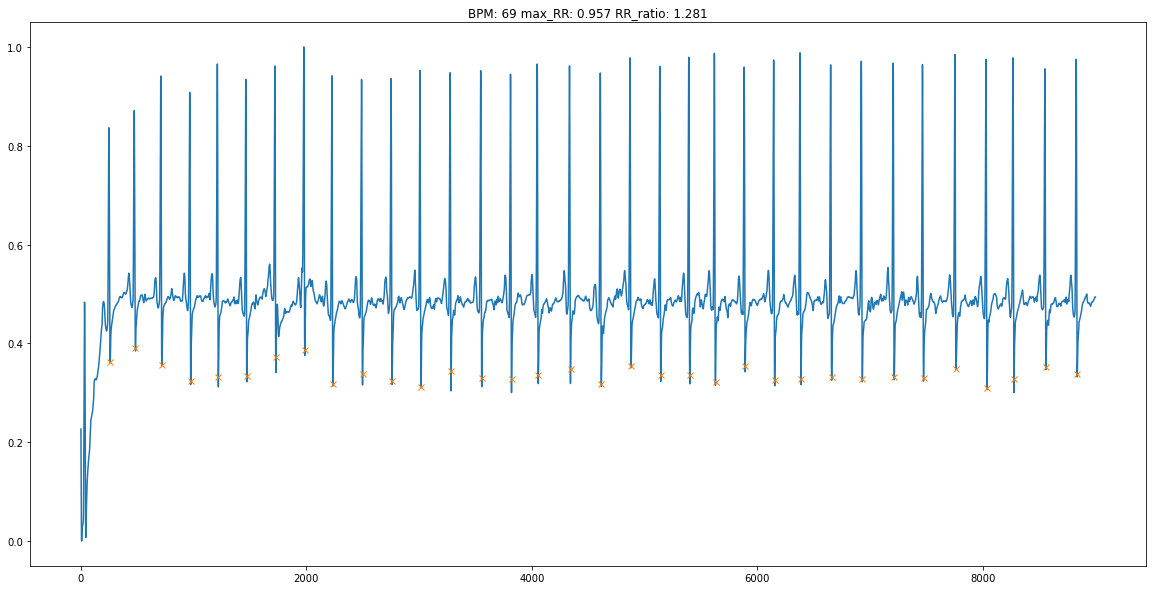

In [137]:
from ecgdetectors import Detectors

fs = 300

detectors = Detectors(fs)

x = training_data['normal'][36]

r_peaks = detectors.swt_detector(x)

fig, axs = plt.subplots(1)
fig.set_size_inches(20, 10)

axs.plot(x)
axs.plot(r_peaks, x[r_peaks], "x")
axs.title.set_text(f"BPM: {get_heart_rate(r_peaks)} max_RR: {get_max_RR(r_peaks)} RR_ratio: {get_RR_ratio(r_peaks)}")



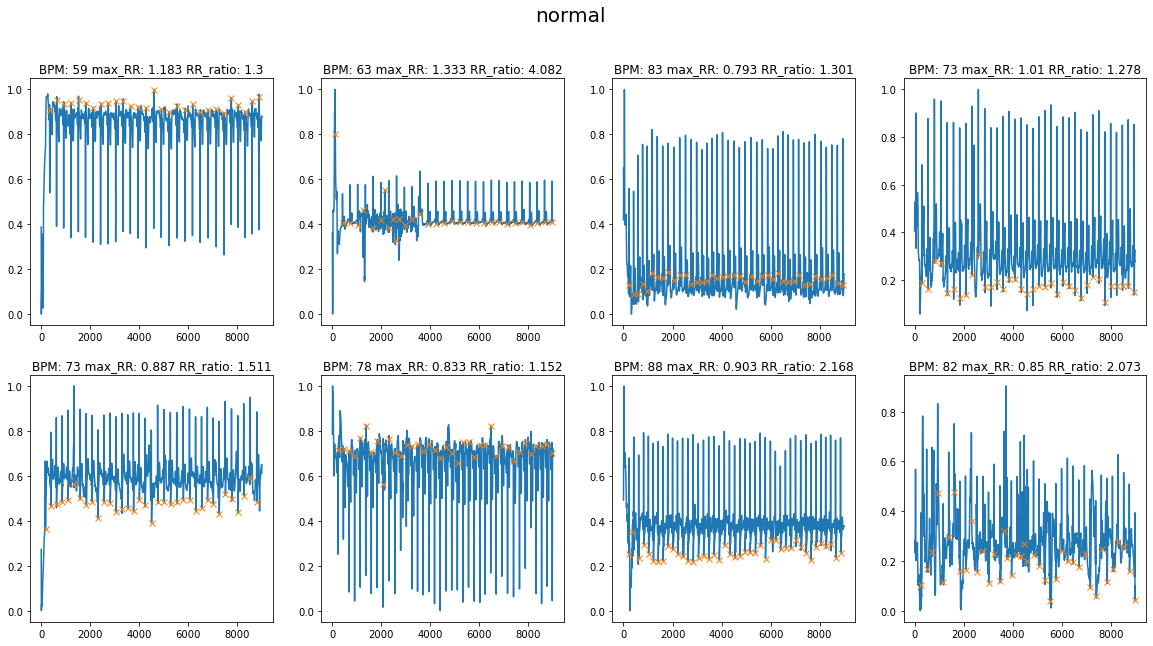

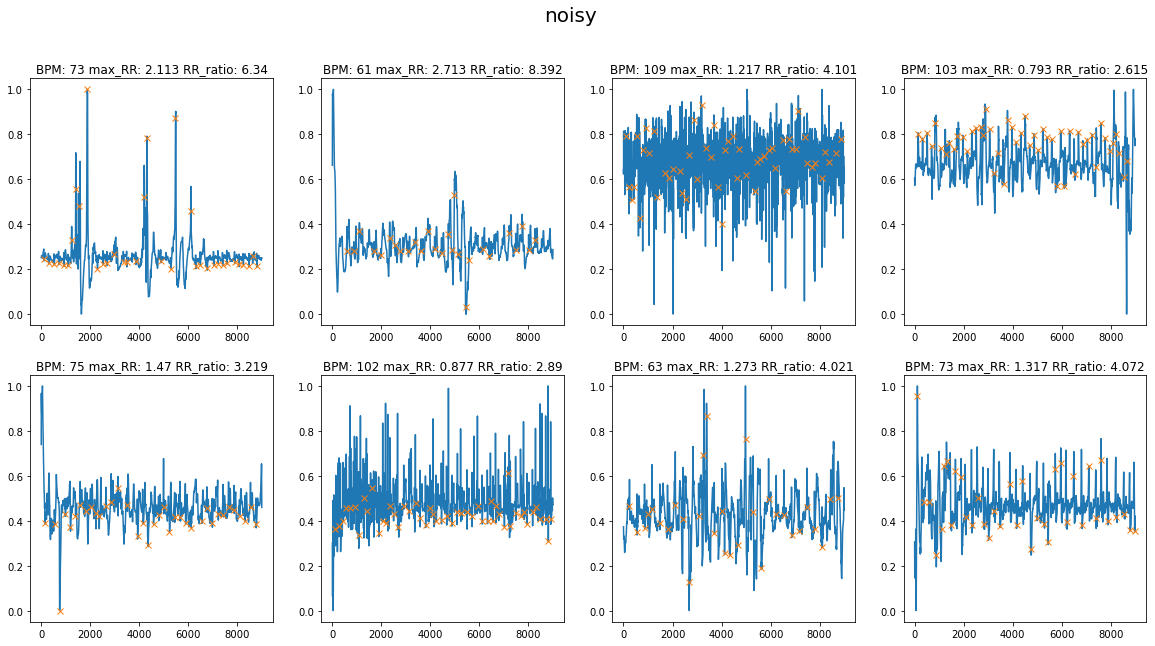

In [146]:
for group in ['normal', 'noisy']:
    fig, axs = plt.subplots(2, 4)
    fig.set_size_inches(20, 10)
    
    random.shuffle(training_data[group])
    fig.suptitle(group, fontsize=20)

    for i in range(8):
        x = training_data[group][i]
        peaks = detectors.swt_detector(x)
        axs[int((i/4) % 2), i%4].plot(x)
        axs[int((i/4) % 2), i%4].plot(peaks, x[peaks], "x")
        axs[int((i/4) % 2), i%4].title.set_text(f"BPM: {get_heart_rate(peaks)} max_RR: {get_max_RR(peaks)} RR_ratio: {get_RR_ratio(peaks)}")


In [213]:
x = {'normal': {'hr': [], 'max_RR': [], 'RR_ratio': []}, 'noisy': {'hr': [], 'max_RR': [], 'RR_ratio': []}}
for group in training_data.keys():
    for i in training_data[group]:
        peaks = detectors.swt_detector(i)
        x[group]['hr'].append(get_heart_rate(peaks))
        x[group]['max_RR'].append(get_max_RR(peaks))
        x[group]['RR_ratio'].append(get_RR_ratio(peaks))
    x[group]['hr'] = np.array(x[group]['hr']).astype('float64')
    x[group]['max_RR'] = np.array(x[group]['max_RR']).astype('float64')
    x[group]['RR_ratio'] = np.array(x[group]['RR_ratio']).astype('float64')

2
Remaining normal data:
paper: 49%
eye-ball: 97%

Remaining noisy data:
paper: 1%
eye-ball: 37%


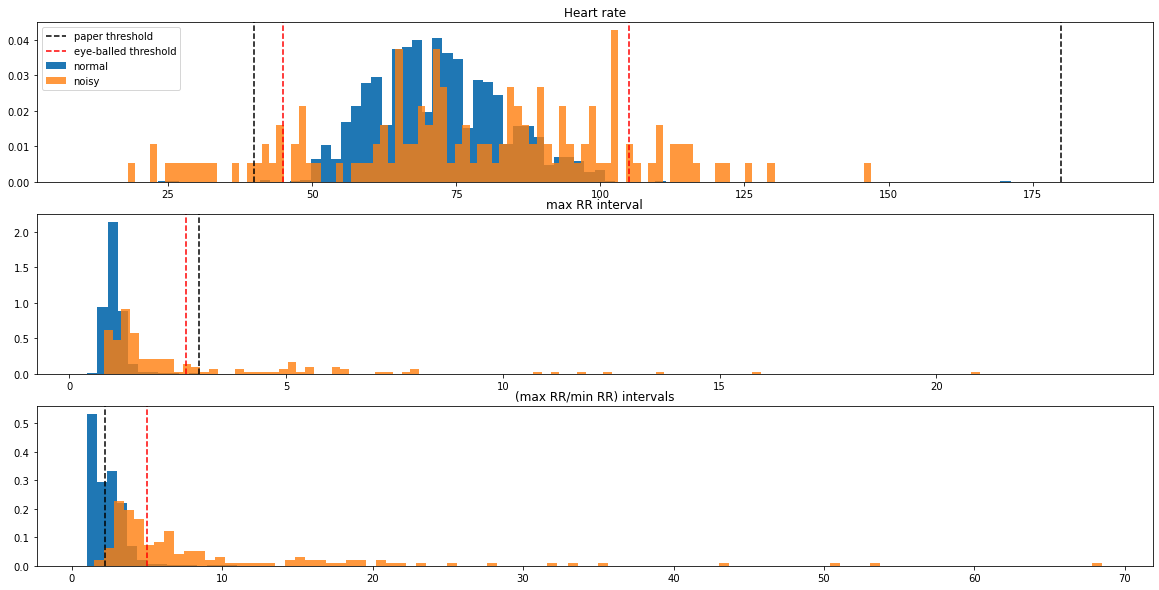

In [238]:
n_bins = 100
fig, axs = plt.subplots(3)
fig.set_size_inches(20, 10)

axs[0].hist(x['normal']['hr'], bins=n_bins, density=True, label='normal');
axs[0].hist(x['noisy']['hr'], alpha=0.8, bins=n_bins, density=True, label='noisy');
axs[0].axvline(x=40, color='k', linestyle='--', label='paper threshold')
axs[0].axvline(x=180, color='k', linestyle='--')
axs[0].axvline(x=45, color='r', linestyle='--', label='eye-balled threshold')
axs[0].axvline(x=105, color='r', linestyle='--')
axs[0].legend()
axs[0].set_title('Heart rate');

axs[1].hist(x['normal']['max_RR'], bins=n_bins, density=True);
axs[1].hist(x['noisy']['max_RR'], alpha=0.8, bins=n_bins, density=True);
axs[1].axvline(x=3, color='k', linestyle='--')
axs[1].axvline(x=2.7, color='r', linestyle='--')
axs[1].set_title('max RR interval');

axs[2].hist(x['normal']['RR_ratio'], bins=n_bins, density=True);
axs[2].hist(x['noisy']['RR_ratio'], alpha=0.8, bins=n_bins, density=True);
axs[2].axvline(x=2.2, color='k', linestyle='--')
axs[2].axvline(x=5, color='r', linestyle='--')
axs[2].set_title('(max RR/min RR) intervals');

x_filtered_paper = {'normal': [], 'noisy': []}
for group in ['normal', 'noisy']:
    for i in range(len(training_data[group])):
        if x[group]['hr'][i] > 40 and x[group]['hr'][i] < 180 and x[group]['max_RR'][i] < 3 and x[group]['RR_ratio'][i] < 2.2:
            x_filtered_paper[group].append(i)

x_filtered_eye = {'normal': [], 'noisy': []}
for group in ['normal', 'noisy']:
    for i in range(len(training_data[group])):
        if x[group]['hr'][i] > 45 and x[group]['hr'][i] < 110 and x[group]['max_RR'][i] < 2.7 and x[group]['RR_ratio'][i] < 5:
            x_filtered_eye[group].append(i)

print(len(x_filtered_paper['noisy']))

print('Remaining normal data:')
print(f"paper: {100*len(x_filtered_paper['normal']) // len(training_data['normal'])}%")
print(f"eye-ball: {100*len(x_filtered_eye['normal']) // len(training_data['normal'])}%\n")

print('Remaining noisy data:')
print(f"paper: {100*len(x_filtered_paper['noisy']) // len(training_data['noisy'])}%")
print(f"eye-ball: {100*len(x_filtered_eye['noisy']) // len(training_data['noisy'])}%")

